In [99]:
import numpy as np
import time
from IPython.display import clear_output

In [136]:
from jupyterplot import ProgressPlot
import matplotlib.pyplot as plt

In [137]:
def alive_wealth_histogram(env):
    w = []
    for i in env.agents:
        w += [i.sugar]
    plt.hist(w,bins=20,density=True)
    plt.show()
    
    
def alive_age_histogram(env):
    w = []
    for i in env.agents:
        w += [i.steps_old/2]
    plt.hist(w,bins=20,density=True)
    plt.show()

In [138]:
class Simple_Agent:
    def __init__(self,environment,posx,posy):
        self.environment = environment
        self.posx = posx
        self.posy = posy
        
        # Caracteristicas
        self.life = np.random.normal(80, 5, None)
        self.sugar = 10
        self.vision = 5
        self.habilidade = 4 #precisa ser maior que metabolismo para que ocorra a acumulacao de capital
        self.metabolismo = 2
        
        # Historico
        self.total_balance = 0
        self.steps_old = 0
        self.children = []
    
    def get_vision(self):
        vision = np.zeros((2*self.vision+1,2*self.vision+1))
        i_vision =0
        j_vision =0
        for i in range(self.posx - self.vision, self.posx + self.vision + 1):
            for j in range(self.posy - self.vision, self.posy + self.vision + 1):
                vision[i_vision][j_vision] = self.environment.get_resource_square(i,j)
                j_vision += 1
            j_vision = 0
            i_vision+=1
        return vision

    def move(self):
        self.vision = 2 + int(self.sugar/5)
        self.habilidade = 3 + int(self.sugar/5)
        vision = self.get_vision()
        x = 0
        y=0
        maior = 0
        # Caso Normal
        for i in range(-1,2):
            for j in range(-1,2):
                atual = vision[self.vision+i][self.vision+j]
                if atual > maior:
                    maior = atual
                    x = i
                    y = j
        if maior > 0:
            return x,y
                
        # Caso Heuristica
        x = 0
        y = 0
        cima = np.sum(vision[:self.vision + 1])
        baixo = np.sum(vision[self.vision:])
        if cima > baixo :
            y = -1
        elif cima<baixo:
            y = 1
            
        cima = np.sum(vision.transpose()[:self.vision + 1])
        baixo = np.sum(vision.transpose()[self.vision:])
        if cima > baixo :
            x = -1
        elif cima<baixo :
            x = 1
        
        if x == 0 and y ==0:
            #caso random
            x = np.random.random()*2 - 1
            x = int(x/abs(x))
            y = np.random.random()*2 - 1
            y = int(y/abs(y))
        return y,x
    
    def add_resource(self, qtd):
        self.sugar += qtd
    
    def life_step(self):
        self.steps_old +=1
        self.total_balance += self.sugar
        if self.sugar >= self.metabolismo:
            if self.sugar >= self.metabolismo*2:
                self.sugar -= self.metabolismo + self.habilidade*self.environment.MPC
            else:
                self.sugar -= self.metabolismo
            self.life -= 0.5
        else:
            self.environment.hungry_agents +=1 
            self.life -= 1.5
            
    def status(self):
        print("life ", np.round(self.life), "sugar", np.round(self.sugar))
            

In [139]:
def grid_rayleigh(size,mu):
    res = np.random.rayleigh(mu,(size,size)).astype(np.int)
    res = res.clip(min=0)
    return res

In [140]:
def grid_random_mask(size,n_clusters,cluster_size):
    if cluster_size>size:
        return None
    res = np.zeros((size+2*cluster_size,size+2*cluster_size),dtype=np.int)
    cluster = np.ones((cluster_size,cluster_size),dtype=np.int)
    for i in range(n_clusters):
        x,y = np.random.randint(cluster_size,size+cluster_size,2)
        res[x:x+cluster_size,y:y+cluster_size] = cluster
    
    return res[cluster_size:cluster_size+size,cluster_size:cluster_size+size]

In [141]:
def grid_random_points_mask(size, n):
    res = np.zeros((size,size))
    random_points = np.random.randint(0,size,(n,2))
    for p in random_points:
        res[p[0]][p[1]] = 1
    return res

In [142]:
class Environment:
    def __init__(self,size,n_agents,step_for_resources = 5):
        self.size = size
        
        self.grid_players = np.zeros((size,size))
        self.grid_resources = np.zeros((size,size))
        self.step_for_resources = step_for_resources
        
        self.agents = []
        self.n_agents = n_agents
        self.dead_agents = []
        
        self.birth_rate = 0.01
        
        self.cluster_n = 5
        self.cluster_size = 10
        self.cluster_renew_time = 5
        self.grid_production_mask = grid_random_mask(self.size,self.cluster_n,self.cluster_size)
        
        self.random_points_number = 50
        
        self.mean_sugar_production_per_square = 1                
        self.sazonality_amplitude = 5
        self.sazonality_period = 5
        
        self.depreciation_percentage = 0.5 ## Warning, can be > 1
        self.depreciation = 1
        
        self.inheritance_tax = 0.8
        
        self.MPC = 0.2 #Marginal Propensity To Consume
        
        
        #############################################
        ############### Log Variables ###############
        #############################################
        
        self.step_counter = 0
        
        self.government = 0
        
        self.current_production = 0
        self.current_accumulation_capacity = 0
        
        self.hungry_agents = 0
        self.current_hunger_deaths = 0 
        
    def get_available_position_on_grid(self):
        pos = np.random.randint(self.size,size=2)
        while self.grid_players[pos[0]][pos[1]]==1:
            pos = np.random.randint(self.size,size=2)
        return pos
    
    def get_available_position_on_grid_next_to(self,posx,posy):
        i = 0
        minimo = 10
        x = posx
        y = posy
        while self.grid_players[posx][(posy + i)%self.size]==1:
            i+=1
        if i< minimo:
            minimo = i
            x = posx
            y = posy + i
            
            
        while self.grid_players[posx][(posy - i)%self.size]==1:
            i+=1
        if i< minimo:
            minimo = i
            x = posx
            y = posy - i
            
        while self.grid_players[(posx+i)%self.size][posy]==1:
            i+=1
        if i< minimo:
            minimo = i
            x = posx+i
            y = posy
            
        while self.grid_players[(posx - i)%self.size][posy]==1:
            i+=1
        if i< minimo:
            minimo = i
            x = posx -i
            y = posy
        return (x,y)
    

    def get_resource_square(self,x,y):
        return self.grid_resources[x%self.size][y%self.size]
    
    def init_simple_agent(self,sugar=5):
        pos = self.get_available_position_on_grid()
        tmp = Simple_Agent(self,pos[0],pos[1])
        tmp.sugar = sugar
        self.agents += [tmp]
        return tmp
        
    def init_agents(self):
        for i in range(self.n_agents):
            self.init_simple_agent();
        
    def init_ordered_grid(self):
        for i in range(self.size):
            for j in range(self.size):
                self.grid_resources[i][j] = i*self.size + j
            
    def init_normal_random_grid(self,mu, var):
        for i in range(self.size):
            for j in range(self.size):
                tmp = np.random.normal(mu,var)//1
                if tmp > 0:
                    self.grid_resources[i][j] = tmp

    def mapa(self):
        mapa = np.zeros((self.size,self.size))
        for i in self.agents:
            mapa[i.posx][i.posy] = 1
        print(mapa)

    def resources(self):
        print(self.grid_resources)
        
    def pmapa(self):
        for i in range(self.size):
            for j in range(self.size):
                if self.grid_players[i][j] == 1:
                    print("(",int(self.grid_resources[i][j]),")\t", end= " ")
                else:
                    print(" ",int(self.grid_resources[i][j])," \t", end= " ")
            print("")
            
            
    def grid_step(self):
        # Mask renew
        if self.step_counter%self.cluster_renew_time == 0:
            self.grid_production_mask = grid_random_mask(self.size,self.cluster_n,self.cluster_size)
        
        # Depreciation
        
        self.grid_resources = self.grid_resources - self.depreciation*grid_random_points_mask(self.size,int(self.depreciation_percentage*(self.size*self.size)))
        self.grid_resources = self.grid_resources.clip(min=0)
        
        # Sazonality
        freq = 2*np.pi*self.step_counter/self.sazonality_period
        sazonal_sugar_production_mean = self.mean_sugar_production_per_square*(100 + self.sazonality_amplitude*np.sin(freq))/100
        
        # Adding resources
        full_harvest = grid_rayleigh(self.size, sazonal_sugar_production_mean)
        if self.step_counter%self.step_for_resources==0:
            rnd_mask = np.logical_or(self.grid_production_mask,grid_random_points_mask(self.size,self.random_points_number))
            self.grid_resources += full_harvest*rnd_mask
        else:    
            self.grid_resources += full_harvest*grid_random_points_mask(self.size,self.random_points_number)

        
#     def renew_grid(self):
#         #depreciacao
#         self.grid_resources = self.grid_resources*(1-self.depreciation)
#         self.grid_resources = self.grid_resources.clip(min=0)
            
#         new_resources = generate_sin_resource_grid(self.size,self.grid_counter/2)
#         soma_total = np.sum(new_resources)
        
#         while soma_total > self.max_sugar_production:
#             x = int(np.random.random()*self.size)
#             y = int(np.random.random()*self.size)
#             soma_total -= new_resources[x][y]
#             new_resources[x][y] = 0
            
#         #sazonalidade
#         new_resources = new_resources*(100 + self.sazonality_percentage*np.sin(self.grid_counter/4))/100
            
            
#         self.grid_counter += 1
#         print("total comida adicionados ", np.sum(new_resources), np.sum(self.grid_resources))
#         self.grid_resources += new_resources
        
    def gini(self):
        w = []
        for i in self.agents:
            w += [i.sugar]
        list.sort(w)

        curve = []
        total = 0

        base_length = 1/len(w)
        gini = 0

        for i in w:
            total += i
            gini += total*base_length


        gini = gini/total
        gini = (0.5 - gini)*2
        return gini
    
    def lorentz_curve(self):
        w = []
        for i in self.agents:
            w += [i.sugar]
        list.sort(w)

        curve = []
        total = 0

        base_length = 1/len(w)
        gini = 0
        for i in w:
            total += i
            gini += total*base_length
            curve += [total]
        curve = curve/total
        
        y = np.arange(0,1,1/len(curve))
        if len(y)> len(curve):
            y = y[0:-1]
            
        plt.plot(y,curve)
        plt.plot([0,np.max(curve)],[0,np.max(curve)])
        plt.show()

    def status_valores_absolutos(self):
        print("gdp: ",self.current_production)
        print("current_accumulation_capacity: ",self.current_accumulation_capacitycurrent_production_capacity) 
        
        
    def step(self):
        
        if len(self.agents)<=0:
            return

        
        
        
                
        #############################################
        ############### Log Variables ###############
        #############################################
        vivos = []
        self.hungry_agents = 0
        self.current_production = 0
        self.current_accumulation_capacitycurrent_production_capacity = 0
        self.current_hunger_deaths = 0





        
        #Add Resources To Grid    
        self.grid_step()
        for agent in self.agents:
            
            # Move
            (x,y)  = agent.move()
            (px,py) = ((agent.posx + x)%self.size, (agent.posy + y)%self.size)

            if self.grid_players[px][py] != 1:
                self.grid_players[agent.posx][agent.posy] = 0
                agent.posx = px
                agent.posy = py
                self.grid_players[px][py] = 1
            
            
            
            # Get Resource
            r = self.grid_resources[agent.posx,agent.posy]
            self.current_accumulation_capacity += agent.habilidade - agent.metabolismo

            if r > agent.habilidade:
                self.current_production += agent.habilidade
                agent.add_resource(agent.habilidade)
                self.grid_resources[agent.posx,agent.posy] -=agent.habilidade
            else:
                self.current_production += r
                agent.add_resource(r)
                self.grid_resources[agent.posx,agent.posy] = 0
                
            # Welfare
            if agent.sugar < agent.metabolismo and self.government > 0 and agent.life > 5:
                t = agent.metabolismo - agent.sugar
                self.government -= t
                agent.sugar += t
                agent.visao = 5
            else:
                agent.visao = 3
                
                
                
            # Life step
            agent.life_step()
            
            if np.random.random()<self.birth_rate:
                self.get_available_position_on_grid_next_to(agent.posx,agent.posy)
                child = self.init_simple_agent(agent.sugar*0.3)
                agent.children += [child]
                agent.sugar = agent.sugar*0.7
            
                
            
             #Death Time
            if agent.life >0:
                vivos += [agent]
            else:                
                if len(agent.children)>0:
                    tax = agent.sugar*self.inheritance_tax
                    self.government += tax
                    agent.sugar -= tax
                    inheritance = agent.sugar/len(agent.children)
                    for c in agent.children:
                        c.sugar += inheritance
                else:
                    self.government += agent.sugar
                if agent.sugar < 2:
                    self.current_hunger_deaths += 1
                self.dead_agents += [agent]
                self.grid_players[agent.posx][agent.posy] = 0            
        #Add live agents 
        self.agents = vivos
        
#         # Add new Agents
#         while len(self.agents)<self.n_agents:
#             self.init_simple_agent()
        
        self.step_counter += 1

# (No Tax)

In [149]:
size = 50
a = Environment(size,100)
a.init_agents()

a.birth_rate = 0.01

a.cluster_n = 16
a.cluster_size = int(size/8)
a.cluster_renew_time = 10

a.random_points_number = int(size*size*0.05)

a.mean_sugar_production_per_square = 3     
a.sazonality_amplitude = 0
a.sazonality_period = 20
a.depreciation = 1
a.depreciation_percentage = 0

a.inheritance_tax = 0

a.MPC = 0

a.step()



## Evolução dos agregados
print_step = 10
pp = ProgressPlot(line_names=["agents", "sugar","fome","GDP","Prod_capa","Gini"])  
c_agents =0
c_production = 0
c_current_accumulation_capacity = 0
c_gini = 0
c_resouces = 0
c_hungry_agents = 0
c_current_hunger_deaths = 0

for i in range(2000):
    c_agents +=len(a.agents)
    c_production += a.current_production
    c_current_accumulation_capacity += a.current_accumulation_capacity
    c_gini += a.gini()
    c_resouces += np.sum(a.grid_resources)
    c_hungry_agents += a.hungry_agents
    c_current_hunger_deaths += a.current_hunger_deaths
    if i%print_step == 0:
        c_agents = c_agents/print_step
        c_production = ((1)*c_production/print_step)/2
        c_current_accumulation_capacity = (1/10)*(c_current_accumulation_capacity/(print_step*c_agents))
        c_gini = (1000)*c_gini/print_step
        c_resouces = (1/10)*c_resouces/print_step
        c_hungry_agents = c_hungry_agents/print_step
        c_current_hunger_deaths = c_current_hunger_deaths/print_step
        pp.update([[c_agents,c_resouces,c_hungry_agents,c_production,c_current_accumulation_capacity,c_gini]])
        c_agents = 0
        c_production = 0
        c_current_accumulation_capacity = 0
        c_gini = 0
        c_resouces = 0
        c_hungry_agents = 0
        c_current_hunger_deaths = 0
    a.step()
pp.finalize()

a.status_valores_absolutos()

## Observação do Mapa
# for i in range(1000):
#     a.step()
#     fig, ax = plt.subplots()
#     res = (a.grid_resources + 6)*(1-a.grid_players)
#     im = ax.imshow(res)


#     fig.tight_layout()

#     time.sleep(1)
#     plt.show()
#     clear_output(wait=True)



gdp:  646.0
current_accumulation_capacity:  0


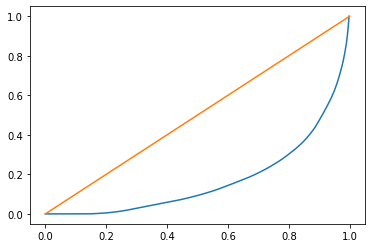

0.659913235202


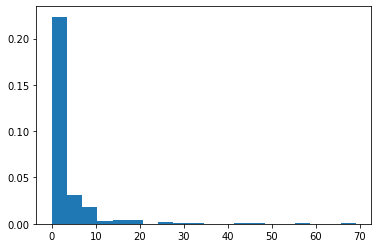

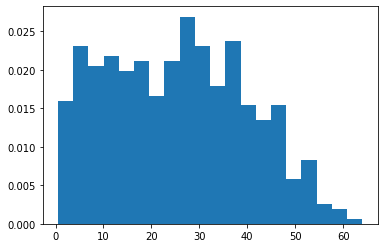

In [150]:
a.lorentz_curve()
print(a.gini())
alive_wealth_histogram(a)
alive_age_histogram(a)

# inheritance tax = 0.3

In [151]:
size = 50
a = Environment(size,100)
a.init_agents()

a.birth_rate = 0.01

a.cluster_n = 16
a.cluster_size = int(size/8)
a.cluster_renew_time = 10

a.random_points_number = int(size*size*0.05)

a.mean_sugar_production_per_square = 3     
a.sazonality_amplitude = 0
a.sazonality_period = 20
a.depreciation = 1
a.depreciation_percentage = 0

a.inheritance_tax = 0.3

a.MPC = 0

a.step()



## Evolução dos agregados
print_step = 10
pp = ProgressPlot(line_names=["agents", "sugar","fome","GDP","Prod_capa","Gini"])  
c_agents =0
c_production = 0
c_current_accumulation_capacity = 0
c_gini = 0
c_resouces = 0
c_hungry_agents = 0
c_current_hunger_deaths = 0

for i in range(2000):
    c_agents +=len(a.agents)
    c_production += a.current_production
    c_current_accumulation_capacity += a.current_accumulation_capacity
    c_gini += a.gini()
    c_resouces += np.sum(a.grid_resources)
    c_hungry_agents += a.hungry_agents
    c_current_hunger_deaths += a.current_hunger_deaths
    if i%print_step == 0:
        c_agents = c_agents/print_step
        c_production = ((1)*c_production/print_step)/2
        c_current_accumulation_capacity = (1/10)*(c_current_accumulation_capacity/(print_step*c_agents))
        c_gini = (1000)*c_gini/print_step
        c_resouces = (1/10)*c_resouces/print_step
        c_hungry_agents = c_hungry_agents/print_step
        c_current_hunger_deaths = c_current_hunger_deaths/print_step
        pp.update([[c_agents,c_resouces,c_hungry_agents,c_production,c_current_accumulation_capacity,c_gini]])
        c_agents = 0
        c_production = 0
        c_current_accumulation_capacity = 0
        c_gini = 0
        c_resouces = 0
        c_hungry_agents = 0
        c_current_hunger_deaths = 0
    a.step()
pp.finalize()

a.status_valores_absolutos()

## Observação do Mapa
# for i in range(1000):
#     a.step()
#     fig, ax = plt.subplots()
#     res = (a.grid_resources + 6)*(1-a.grid_players)
#     im = ax.imshow(res)


#     fig.tight_layout()

#     time.sleep(1)
#     plt.show()
#     clear_output(wait=True)

gdp:  837.0
current_accumulation_capacity:  0


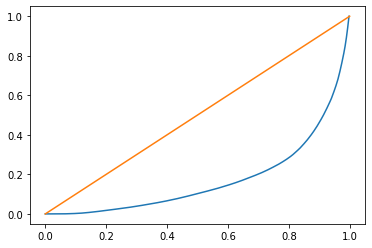

0.656048816208


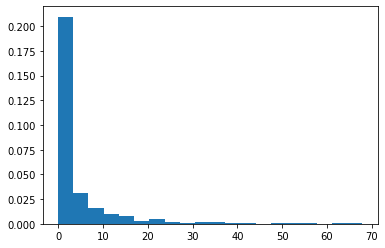

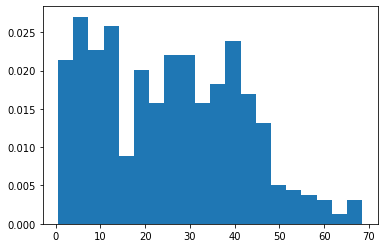

In [152]:
a.lorentz_curve()
print(a.gini())
alive_wealth_histogram(a)
alive_age_histogram(a)

# Inheritance Tax = 0.7

In [153]:
size = 50
a = Environment(size,100)
a.init_agents()

a.birth_rate = 0.01

a.cluster_n = 16
a.cluster_size = int(size/8)
a.cluster_renew_time = 10

a.random_points_number = int(size*size*0.05)

a.mean_sugar_production_per_square = 3     
a.sazonality_amplitude = 0
a.sazonality_period = 20
a.depreciation = 1
a.depreciation_percentage = 0

a.inheritance_tax = 0.7

a.MPC = 0

a.step()



## Evolução dos agregados
print_step = 10
pp = ProgressPlot(line_names=["agents", "sugar","fome","GDP","Prod_capa","Gini"])  
c_agents =0
c_production = 0
c_current_accumulation_capacity = 0
c_gini = 0
c_resouces = 0
c_hungry_agents = 0
c_current_hunger_deaths = 0

for i in range(2000):
    c_agents +=len(a.agents)
    c_production += a.current_production
    c_current_accumulation_capacity += a.current_accumulation_capacity
    c_gini += a.gini()
    c_resouces += np.sum(a.grid_resources)
    c_hungry_agents += a.hungry_agents
    c_current_hunger_deaths += a.current_hunger_deaths
    if i%print_step == 0:
        c_agents = c_agents/print_step
        c_production = ((1)*c_production/print_step)/2
        c_current_accumulation_capacity = (1/10)*(c_current_accumulation_capacity/(print_step*c_agents))
        c_gini = (1000)*c_gini/print_step
        c_resouces = (1/10)*c_resouces/print_step
        c_hungry_agents = c_hungry_agents/print_step
        c_current_hunger_deaths = c_current_hunger_deaths/print_step
        pp.update([[c_agents,c_resouces,c_hungry_agents,c_production,c_current_accumulation_capacity,c_gini]])
        c_agents = 0
        c_production = 0
        c_current_accumulation_capacity = 0
        c_gini = 0
        c_resouces = 0
        c_hungry_agents = 0
        c_current_hunger_deaths = 0
    a.step()
pp.finalize()

a.status_valores_absolutos()

## Observação do Mapa
# for i in range(1000):
#     a.step()
#     fig, ax = plt.subplots()
#     res = (a.grid_resources + 6)*(1-a.grid_players)
#     im = ax.imshow(res)


#     fig.tight_layout()

#     time.sleep(1)
#     plt.show()
#     clear_output(wait=True)

gdp:  813.0
current_accumulation_capacity:  0


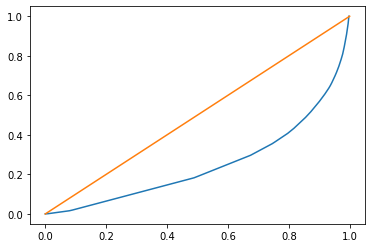

0.502443436582


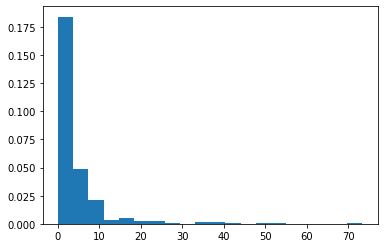

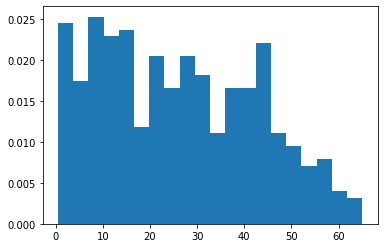

In [72]:
a.lorentz_curve()
print(a.gini())
alive_wealth_histogram(a)
alive_age_histogram(a)

# Inheritance tax = 1

In [42]:
size = 50
a = Environment(size,100)
a.init_agents()

a.birth_rate = 0.01

a.cluster_n = 16
a.cluster_size = int(size/8)
a.cluster_renew_time = 10

a.random_points_number = int(size*size*0.05)

a.mean_sugar_production_per_square = 3     
a.sazonality_amplitude = 0
a.sazonality_period = 20
a.depreciation = 1
a.depreciation_percentage = 1

a.inheritance_tax = 1

a.step()



## Evolução dos agregados

pp = ProgressPlot(line_names=["agents", "sugar","fome","GDP","Prod_capa","Gini"])  
c_agents =0
c_production = 0
c_production_capacity = 0
c_gini = 0
c_resouces = 0
c_hungry_agents = 0
for i in range(2000):
    c_agents +=len(a.agents)
    c_production += a.current_production
    c_production_capacity += a.current_production_capacity
    c_gini += a.gini()
    c_resouces += np.sum(a.grid_resources)
    c_hungry_agents += a.hungry_agents
    if i%10 == 0:
        pp.update([[c_agents/10,c_resouces/50,c_hungry_agents/10,c_production/10,c_production_capacity/100,1000*a.gini()]])
        c_agents = 0
        c_production = 0
        c_production_capacity = 0
        c_gini = 0
        c_resouces = 0
        c_hungry_agents = 0
    a.step()
pp.finalize()

a.status_valores_absolutos()

## Observação do Mapa
# for i in range(1000):
#     a.step()
#     fig, ax = plt.subplots()
#     res = (a.grid_resources + 6)*(1-a.grid_players)
#     im = ax.imshow(res)


#     fig.tight_layout()

#     time.sleep(1)
#     plt.show()
#     clear_output(wait=True)





gdp:  492.0
production capacity:  1200


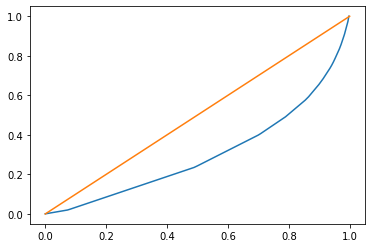

0.397589628912


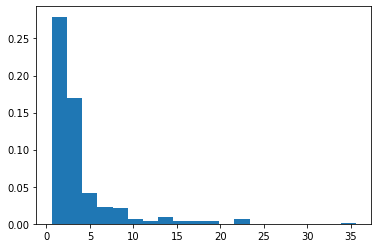

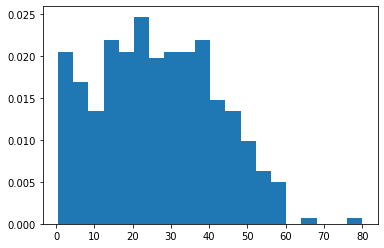

In [43]:
a.lorentz_curve()
print(a.gini())
alive_wealth_histogram(a)
alive_age_histogram(a)

In [67]:
a = Environment(50,100,step_for_resources=5)
a.max_sugar_production = 1000
a.init_agents()
a.birth_rate = 0.015
pp = ProgressPlot(line_names=["agents", "sugar stock","Gini Index"])

for i in range(400):
    a.step()
    if i%10 == 0:
        print(len(a.agents))
        pp.update([[len(a.agents),np.sum(a.grid_resources)/10,a.gini()*100]])
    
pp.finalize()

103
118
133
155
178
208
193
145
147
153
165
157
149
147
163
160
145
141
141
150
127
119
119
123
136
130
130
129
136
127
117
119
133
128
123
118
110
107
100
101


In [84]:
a = Environment(10,1,step_for_resources=3)

a.cluster_n = 2
a.cluster_size = 2
a.cluster_renew_time = 4

a.random_points_number = 2

a.mean_sugar_production_per_square = 2

a.init_agents()
for i in range(100):
    time.sleep(3)
    clear_output(wait=True)
    a.pmapa()
    a.step()

  0  	   0  	   0  	   0  	   0  	   1  	   0  	   0  	   0  	   0  	 
  0  	   0  	   2  	   2  	   0  	   0  	   0  	   0  	   0  	   6  	 
  0  	   0  	   0  	   2  	   7  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   2  	   1  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	 
  0  	 ( 0 )	   0  	   4  	   7  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   1  	   3  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	 
  0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	   0  	 


KeyboardInterrupt: 

In [17]:
size = 200
a = Environment(size,1000)
a.init_agents()

a.birth_rate = 0.01

a.cluster_n = 16
a.cluster_size = int(size/8)
a.cluster_renew_time = 10

a.random_points_number = int(size*size*0.05)

a.mean_sugar_production_per_square = 3     
a.sazonality_amplitude = 0
a.sazonality_period = 20
a.depreciation = 1

a.inheritance_tax = 0

a.step()



## Evolução dos agregados

pp = ProgressPlot(line_names=["agents", "sugar stock","Fome","GDP","Production_capacity"])   
for i in range(1200):
    if i%10 == 0:
        pp.update([[np.sum(a.grid_resources)/10000,a.hungry_agents/100,a.current_production/100,a.current_production_capacity/100]])
    a.step()
pp.finalize()

a.status_valores_absolutos()

## Observação do Mapa
# for i in range(1000):
#     a.step()
#     fig, ax = plt.subplots()
#     res = (a.grid_resources + 6)*(1-a.grid_players)
#     im = ax.imshow(res)


#     fig.tight_layout()

#     time.sleep(1)
#     plt.show()
#     clear_output(wait=True)




<IPython.core.display.Javascript object>

KeyboardInterrupt: 